# Задача 2. Сравнение методов классификации

* **Дедлайн**: 20.11.2022, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 9

## Задача

- [x] Самостоятельно реализовать один из методов классификации, с возможностью настройки гиперпараметров.
- [x] Взять данные для предсказания заболеваний сердца [тут](https://github.com/rustam-azimov/ml-course/tree/main/data/heart_disease) (целевой признак для предсказания --- **target**). Демо блакнот с анализом этих данных можно найти [тут](https://github.com/rustam-azimov/ml-course/blob/main/practice/practice07_knn_nb/practice07_part02_classification_heart_disease_demo.ipynb).
- [x] Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (**Data Cleaning**).
- [x] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи классификации.
- [x] При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
- [x] Используя **подбор гиперпараметров**, **кросс-валидацию** и при необходимости **масштабирование данных**, добиться наилучшего качества предсказания от Вашей реализации на выделенной заранее тестовой выборке.
- [x] Повторить предыдущий пункт для библиотечных реализаций (например, из **sklearn**) всех пройденных методов классификации (**logistic regression, svm, knn, naive bayes, decision tree**).
- [x] Сравнить все обученные модели, построить их **confusion matrices**. Сделать выводы о полученных моделях в рамках решения задачи классификации на выбранных данных.
- [x] * (**+2 балла**) Реализовать еще один из методов классификации и добавить его в сравнение.
- [x] * (**+2 балла**) Найти данные, на которых интересно будет решать задачу классификации. Повторить все пункты задания на новых данных.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

In [2]:
sns.set(font_scale=1.5)
sns.set(rc={'figure.figsize':(10, 8)})

# MyLogisticRegression

In [3]:
class MyLogisticRegression:
    def __init__(self, iterations=1000, lr=1e-2, threshold=0.5):
        self.iterations = iterations
        self.lr = lr
        self.threshold = threshold
        self.w = None
    
    @staticmethod
    def sigmoid(h):
        return 1. / (1 + np.exp(-h))
    
    @staticmethod
    def logit(x, w):
        return np.dot(x, w)    
        
    def fit(self, X, y):
        n, k = X.shape
        if self.w is None:
            np.random.seed(42)
            self.w = np.random.randn(k + 1)
        X_train = np.concatenate((np.ones((n, 1)), X), axis=1)
        for _ in range(self.iterations):
            y_pred = self.sigmoid(self.logit(X_train, self.w))
            self.w -= self.lr * self.get_grad(X_train, y, y_pred)
            
    def get_grad(self, X, y, predictions):
        grad = -np.dot(X.T, y * (1 - predictions) - (1 - y) * predictions)
        return grad
    
    def predict_prob(self, X):
        n, k = X.shape
        X_ = np.concatenate((np.ones((n, 1)), X), axis=1)
        return self.sigmoid(self.logit(X_, self.w))
    
    def predict(self, X):
        return self.predict_prob(X) >= self.threshold
    
    def get_params(self, deep=True):
        return {
            "iterations": self.iterations,
            "lr": self.lr,
            "threshold": self.threshold,
        }

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

## MyKNN

In [4]:
from scipy.stats import mode

class MyKNeighborsClassifier:
    def __init__(self, k=5):
        self.k = k
        self.dist = lambda x, y: ((x - y[:, None]) ** 2).sum(-1)
        self.X_train = None
        self.y_train = None
        
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        
    def predict(self, X):
        distance = self.dist(self.X_train, X)
        indexes = np.argpartition(distance, 1)[:, : self.k]
        neighbours = np.array([[self.y_train[i] for i in idx] for idx in indexes])
        return mode(neighbours, axis=1).mode.flatten()

    def get_params(self, deep=True):
        return {"k": self.k}
                    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

# Read dataset

In [5]:
df = pd.read_csv('../data/heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


Описание датасета ([link](https://www.kaggle.com/code/ahmedadell30/heart-disease-prediction-with-ann-models/data)):

- age - age in years
- sex - (1 = male; 0 = female)
- cp - chest pain type
- trestbps - resting blood pressure (in mm Hg on admission to the hospital)
- chol - serum cholestoral in mg/dl
- fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
- restecg - resting electrocardiographic results
- thalach - maximum heart rate achieved
- exang - exercise induced angina (1 = yes; 0 = no)
- oldpeak - ST depression induced by exercise relative to rest
- slope - the slope of the peak exercise ST segment
- ca - number of major vessels (0-3) colored by flourosopy
- thal - 3 = normal; 6 = fixed defect; 7 = reversable defect
- target - have disease or not (1=yes, 0=no)

Ключевой признак -- target, имеет ли пациент заболевание сердца

# EDA

In [6]:
df.target.value_counts()

1    526
0    499
Name: target, dtype: int64

Классы признака приблизительно одной мощности

In [7]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Пропущенных значений нет

In [8]:
df.groupby('target').mean()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
target,,,,,,,,,,,,,
0,56.569138,0.827655,0.482966,134.106212,251.292585,0.164329,0.456914,139.130261,0.549098,1.600200,1.166333,1.158317,2.539078
1,52.408745,0.570342,1.378327,129.245247,240.979087,0.134981,0.598859,158.585551,0.134981,0.569962,1.593156,0.370722,2.119772


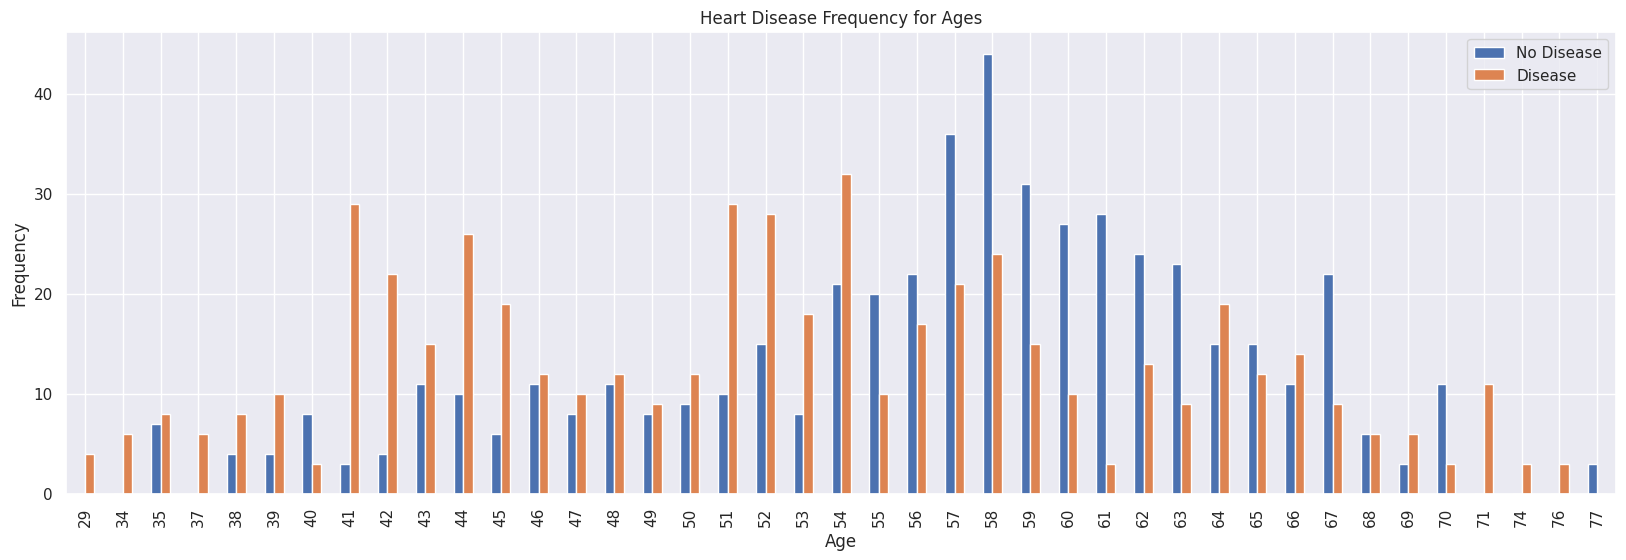

In [9]:
pd.crosstab(df.age,df.target).plot(kind="bar",figsize=(20,6))
plt.title('Heart Disease Frequency for Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend(["No Disease", "Disease"])
plt.show()

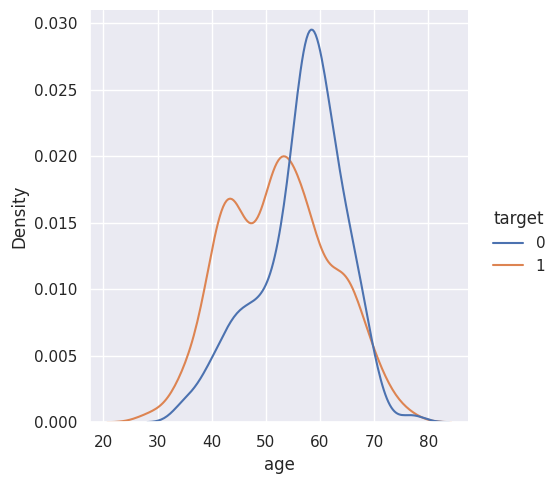

In [10]:
sns.displot(df, x='age', kind='kde', hue='target', height=5);

Пик сердечных заболеваний приходится на возрастной диапазон 41-54 года. Пиковая возрастная группа для здоровых людей -- 56-62 года

Посмотрим на зависимость целевого признака от пола

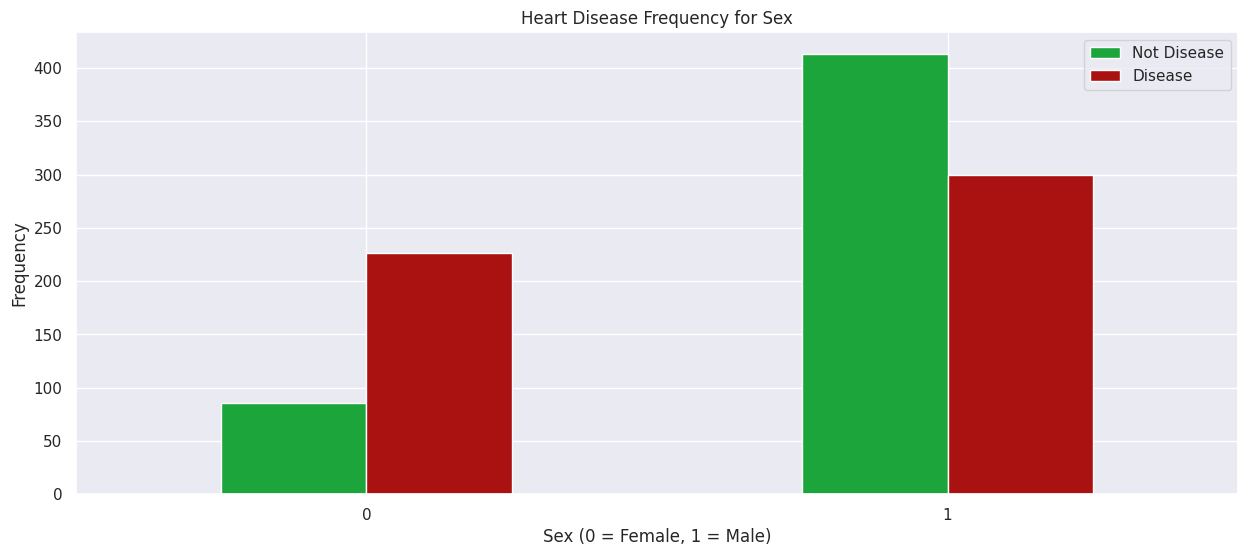

In [11]:
pd.crosstab(df.sex,df.target).plot(kind="bar", figsize=(15, 6), color=['#1CA53B', '#AA1111' ])
plt.title('Heart Disease Frequency for Sex')
plt.xlabel('Sex (0 = Female, 1 = Male)')
plt.xticks(rotation=0)
plt.legend(["Not Disease", "Disease"])
plt.ylabel('Frequency')
plt.show()

Среди мужчин больше записей с отсутствующими заболеваниями сердца, тогда как среди женщин преобладают записи с имеющимися заболеваниями

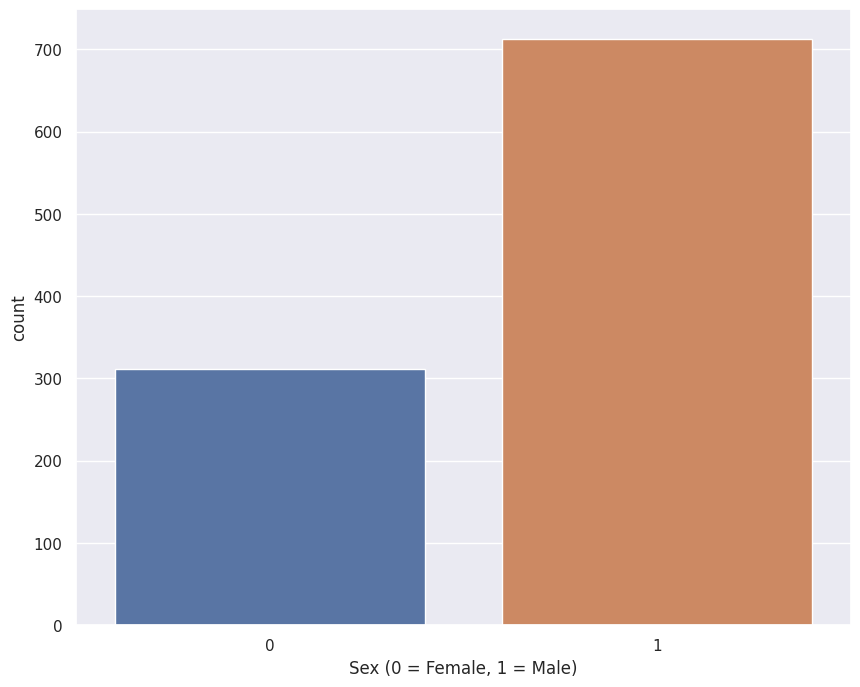

In [12]:
sns.countplot(x="sex", data=df)
plt.xlabel("Sex (0 = Female, 1 = Male)");

Заметим, что в данных более чем в два раза больше записей о людях мужского пола

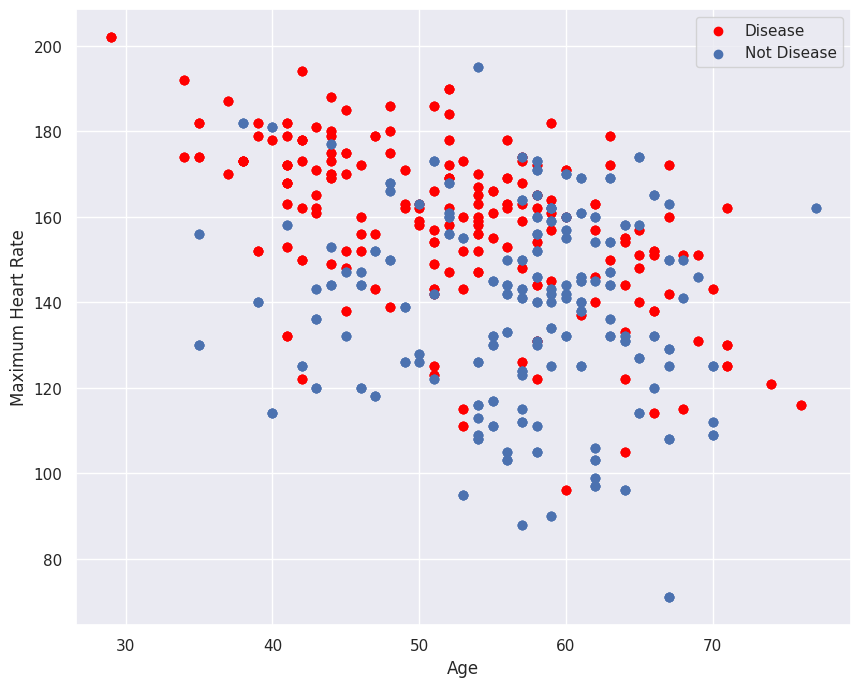

In [13]:
plt.scatter(x=df.age[df.target==1], y=df.thalach[(df.target==1)], c="red")
plt.scatter(x=df.age[df.target==0], y=df.thalach[(df.target==0)])
plt.legend(["Disease", "Not Disease"])
plt.xlabel("Age")
plt.ylabel("Maximum Heart Rate")
plt.show()

В молодом возрасте учащенное сердцебиение чаще влечёт за собой наличие заболевания

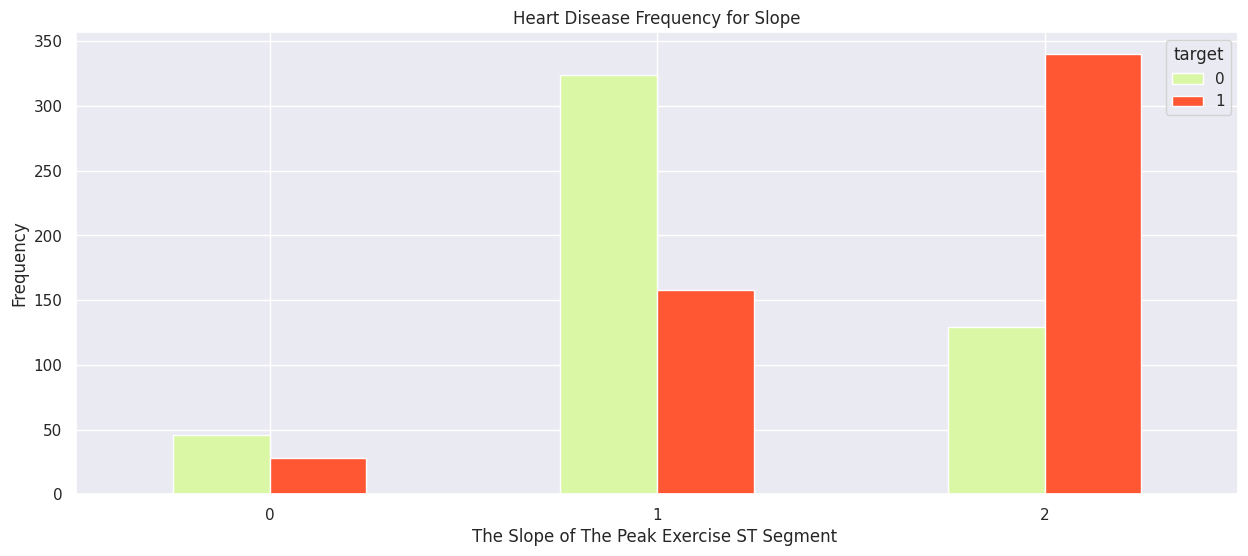

In [14]:
pd.crosstab(df.slope,df.target).plot(kind="bar", figsize=(15, 6), color=['#DAF7A6','#FF5733' ])
plt.title('Heart Disease Frequency for Slope')
plt.xlabel('The Slope of The Peak Exercise ST Segment ')
plt.xticks(rotation = 0)
plt.ylabel('Frequency')
plt.show()

Люди во второй категории признака slope чаще имеют сердечные заболевания

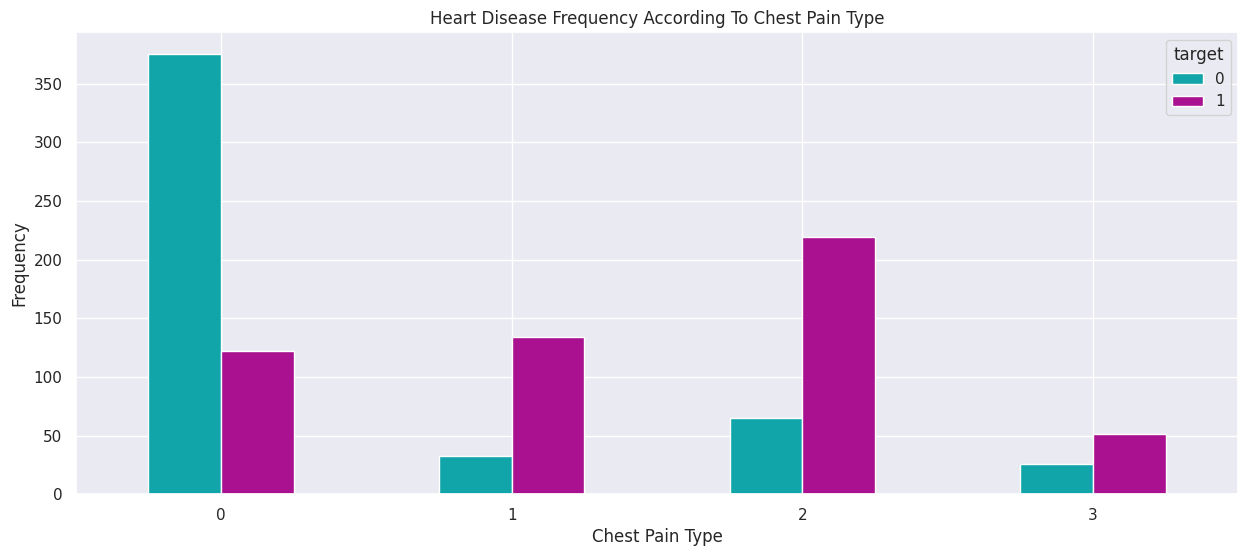

In [15]:
pd.crosstab(df.cp,df.target).plot(kind="bar",figsize=(15, 6), color=['#11A5AA','#AA1190' ])
plt.title('Heart Disease Frequency According To Chest Pain Type')
plt.xlabel('Chest Pain Type')
plt.xticks(rotation = 0)
plt.ylabel('Frequency')
plt.show()

Люди с нулевым типом грудной боли чаще не имеют сердечных заболеваний

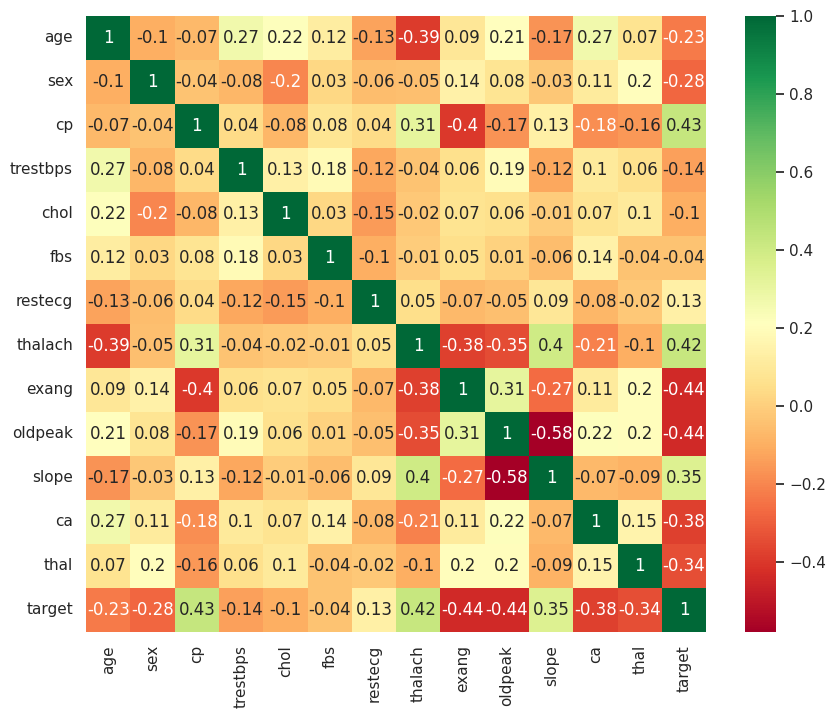

In [16]:
sns.heatmap(round(df.corr(), 2), annot=True, cmap='RdYlGn')
fig = plt.gcf()
plt.show()

Заметим, что наибольшашя корреляция у целевого признака с признаками **cp, thalach, slope**

# Feature Engineering

Закодируем категориальные признаки

In [17]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

In [18]:
transformer = make_column_transformer(
    (OneHotEncoder(drop="first"), ["sex", "cp", "fbs", "restecg", "exang", "ca", "thal"]),
    remainder='passthrough')

transformed = transformer.fit_transform(df)
df = pd.DataFrame(transformed, columns=transformer.get_feature_names())

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
y = df['target']
X = df.drop(columns=['target'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

Отмасштабируем численные признаки

In [21]:
from sklearn.preprocessing import StandardScaler

In [22]:
scaler = StandardScaler()  # воспользуемся стандартным трансформером

# масштабируем обучающую выборку и запоминаем среднее, стандартное отклонение признаков
X_train_scaled = scaler.fit_transform(X_train)

# масштабируем тестовую выборку используя статистики обучающей выборки
X_test_scaled = scaler.transform(X_test)

In [23]:
accuracies = {}
pred = {}

# RFE

In [24]:
from sklearn.linear_model import LogisticRegression

In [25]:
from sklearn.feature_selection import RFECV

In [26]:
rfecv = RFECV(estimator=LogisticRegression())

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

rfecv.fit(X_train_scaled, y_train)
selected_features = list(X_train_scaled.columns[rfecv.support_])

In [27]:
X_train_scaled = X_train_scaled[selected_features]
X_test_scaled = X_test_scaled[selected_features]

# My Logistic Regression

In [28]:
from sklearn.metrics import accuracy_score

In [29]:
from sklearn.model_selection import GridSearchCV

In [30]:
searcher = GridSearchCV(
    MyLogisticRegression(),
    [{"threshold": np.logspace(-5, 3, 20)}],
    scoring="f1",
    cv=10
)

searcher.fit(X_train_scaled, y_train);

In [31]:
logreg = MyLogisticRegression(threshold=searcher.best_params_["threshold"])
logreg.fit(X_train_scaled.to_numpy(), y_train.to_numpy())
y_pred = logreg.predict(X_test_scaled)
print("Accuracy MyLogisticRegression: ", accuracy_score(y_test, y_pred))

accuracies["MyLogisticRegression"] = accuracy_score(y_test, y_pred)
pred["MyLogisticRegression"] = y_pred

Accuracy MyLogisticRegression:  0.8214285714285714


## Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression

In [33]:
searcher = GridSearchCV(
    LogisticRegression(),
    param_grid=[{'C': np.logspace(-5, 3, 20)}],
    scoring="f1",
    cv=10,
)

searcher.fit(X_train_scaled, y_train);

In [34]:
logreg = LogisticRegression(C=searcher.best_params_["C"])
logreg.fit(X_train_scaled.to_numpy(), y_train.to_numpy())
y_pred = logreg.predict(X_test_scaled)
print("Accuracy sklearn LogisticRegression: ", accuracy_score(y_test, y_pred))

accuracies["LogisticRegression"] = accuracy_score(y_test, y_pred)
pred["LogisticRegression"] = y_pred

Accuracy sklearn LogisticRegression:  0.8116883116883117


## SVM

In [35]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

C = [0.1, 0.25, 0.5, 0.75, 1, 2]
kernel = ["linear", "rbf"]
gamma = ["scale", "auto", 0.0001, 0.001, 0.01, 0.1, 1]

cv = StratifiedKFold(10)

svm = SVC(random_state=11)
grid_svm = GridSearchCV(
    estimator=svm, cv=cv, 
    param_grid=dict(kernel=kernel,C=C, gamma=gamma),
    scoring="f1"
)
grid_svm.fit(X_train_scaled, y_train);

In [36]:
svm = SVC(C=grid_svm.best_params_['C'], gamma=grid_svm.best_params_['gamma'], 
          kernel=grid_svm.best_params_['kernel'], random_state = 11)
svm.fit(X_train_scaled, y_train)
y_pred = svm.predict(X_test_scaled)
print("Accuracy SVM:", accuracy_score(y_test, y_pred))

accuracies["SVM"] = accuracy_score(y_test, y_pred)
pred["SVM"] = y_pred

Accuracy SVM: 0.9383116883116883


## My KNN

In [37]:
grid_myknn = GridSearchCV(
    estimator=MyKNeighborsClassifier(),
    param_grid=[{'k': [1, 3, 5, 8]}],
    scoring="f1",
    cv=5,
)

grid_myknn.fit(X_train_scaled.to_numpy(), y_train.to_numpy());

In [38]:
my_knn = MyKNeighborsClassifier(k=grid_myknn.best_params_['k'])
my_knn.fit(X_train_scaled.to_numpy(), y_train.to_numpy())
y_pred = my_knn.predict(X_test_scaled.to_numpy())
print("Accuracy MyKNN:", accuracy_score(y_test, y_pred))

accuracies["MyKNN"] = accuracy_score(y_test, y_pred)
pred["MyKNN"] = y_pred

Accuracy MyKNN: 0.9902597402597403


## KNN

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=11)

grid_knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    cv=cv,
    param_grid={"n_neighbors": np.arange(1, 11, 2), "weights": ['uniform', 'distance']},
    scoring="f1"
)

grid_knn.fit(X_train_scaled, y_train);

In [40]:
knn = KNeighborsClassifier(n_neighbors=grid_knn.best_params_['n_neighbors'],
                           weights=grid_knn.best_params_['weights'])

knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)
print("Accuracy KNN:", accuracy_score(y_test, y_pred))

accuracies["KNN"] = accuracy_score(y_test, y_pred)
pred["KNN"] = y_pred

Accuracy KNN: 1.0


## NB

In [41]:
from sklearn.naive_bayes import GaussianNB

priors = [None, [0.62, 0.38]]
var_smoothing = np.logspace(0, -9, num=100)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=11)
grid_nb = GridSearchCV(
    estimator=GaussianNB(),
    cv=cv,
    param_grid={"priors": priors, "var_smoothing": var_smoothing},
    scoring="f1"
)
grid_nb.fit(X_train_scaled, y_train);

In [42]:
nb = GaussianNB(priors=grid_nb.best_params_['priors'],
                var_smoothing=grid_nb.best_params_['var_smoothing'])

nb.fit(X_train_scaled, y_train)
y_pred = nb.predict(X_test_scaled)
print("Accuracy NB:", accuracy_score(y_test, y_pred))

accuracies["NaiveBayes"] = accuracy_score(y_test, y_pred)
pred["NaiveBayes"] = y_pred

Accuracy NB: 0.8214285714285714


## Decision Tree

In [43]:
from sklearn.tree import DecisionTreeClassifier

max_depth = np.arange(7, 15)
min_samples_split = [2, 4, 5, 10]
min_samples_leaf = [1, 2, 4, 6]

cv = StratifiedKFold(10)
grid_tree = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=11),
    cv=5,
    param_grid={'max_depth': max_depth, 
                "min_samples_split": min_samples_split, 
                "min_samples_leaf": min_samples_leaf
    },
    scoring="f1"
)
grid_tree.fit(X_train_scaled, y_train);

In [44]:
dtree = DecisionTreeClassifier(
    max_depth=grid_tree.best_params_['max_depth'],
    min_samples_split=grid_tree.best_params_['min_samples_split'],
    min_samples_leaf=grid_tree.best_params_['min_samples_leaf']
)

dtree.fit(X_train_scaled, y_train)
y_pred = dtree.predict(X_test_scaled)

print("Accuracy DecisionTree:", accuracy_score(y_test, y_pred))

accuracies["DecisionTree"] = accuracy_score(y_test, y_pred)
pred["DecisionTree"] = y_pred

Accuracy DecisionTree: 0.9707792207792207


## Method Comparison

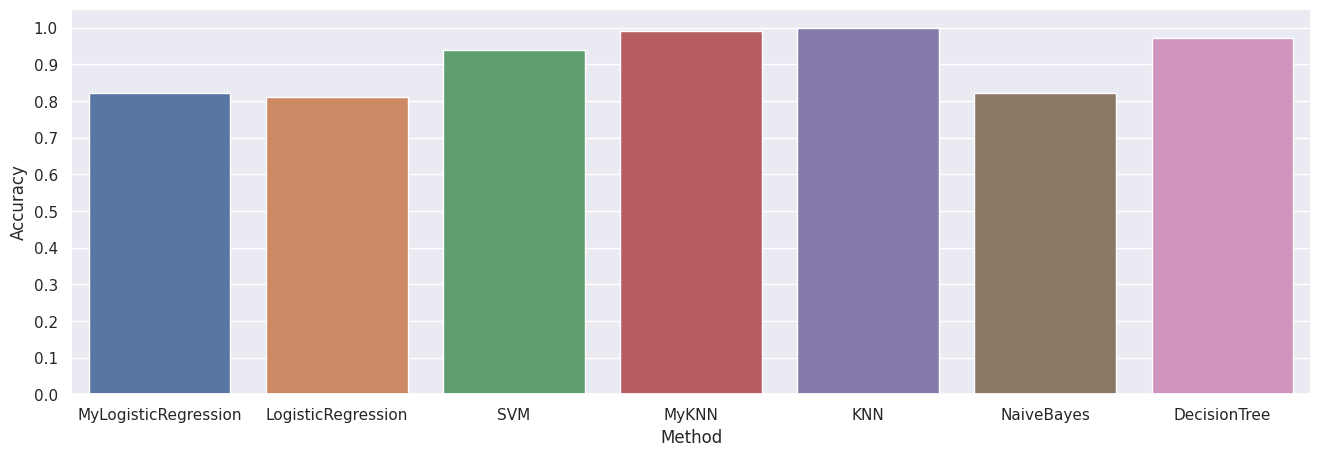

In [45]:
plt.figure(figsize=(16, 5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Accuracy")
plt.xlabel("Method")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.show()

## Confusion Matrix

In [46]:
from sklearn.metrics import confusion_matrix

In [47]:
cm = {
    key: confusion_matrix(y_test, pred[key]) for key in pred.keys()
}

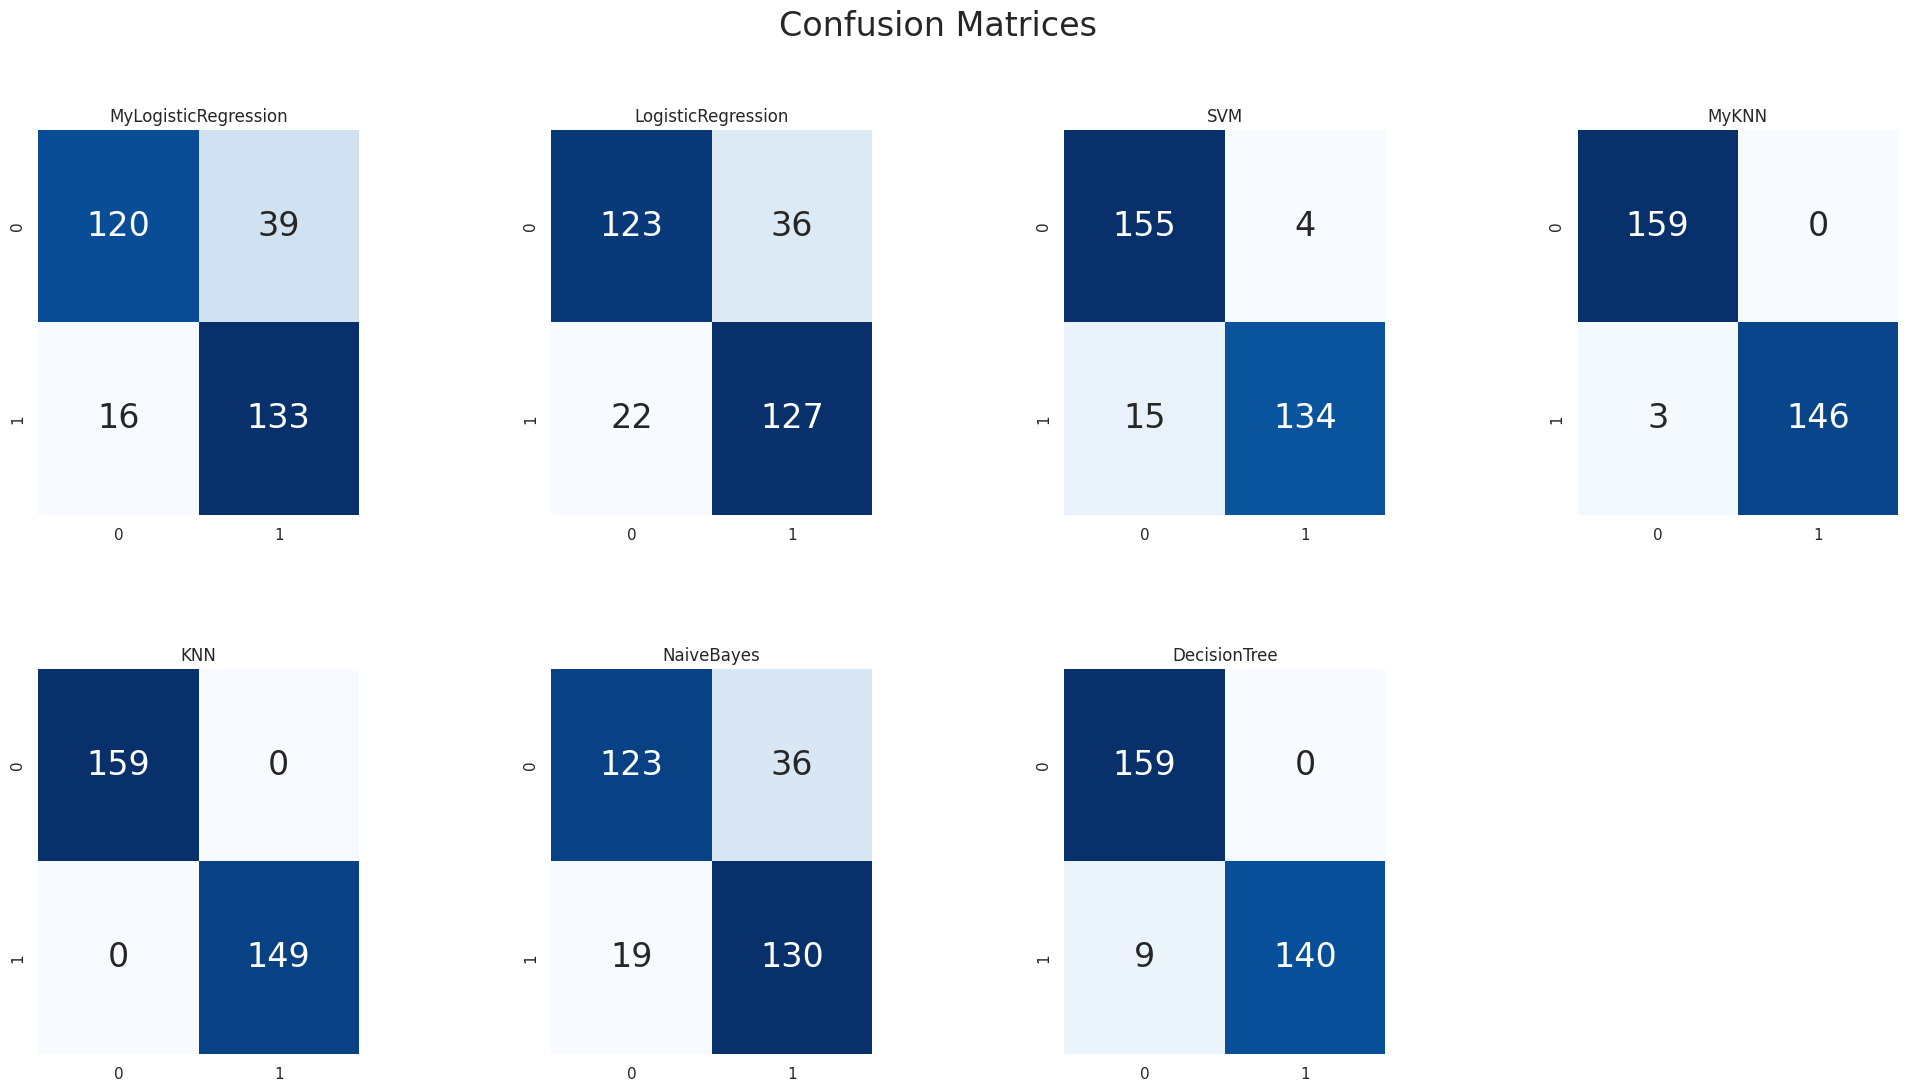

In [48]:
plt.figure(figsize=(24, 12))

plt.suptitle("Confusion Matrices", fontsize=24)
plt.subplots_adjust(wspace=0.6, hspace=0.4)

for i, key in enumerate(cm.keys()):
    plt.subplot(2, 4, i + 1)
    plt.title(key)
    sns.heatmap(cm[key],annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

# Выводы

Реализованные версии логистической регрессии и KNN по качеству предсказания получились близкими к оригиналу. Наивысшее значение accuracy показали оба KNN и решающие деревья. Логрег и наивный байесовский классификатор вместе показали сравнительно худшие результаты.

Подобная разница между результатами линрега и KNN может быть обусловлена линейной неразделимостью выборки. 

# Новый датасет

In [49]:
df = pd.read_csv('../data/BankNote_Authentication.csv')
df.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


Описание датасета ([link](https://www.kaggle.com/datasets/ritesaluja/bank-note-authentication-uci-data)):

- variance -- variance of Wavelet Transformed image (continuous)
- skewness -- skewness of Wavelet Transformed image (continuous)
- curtosis -- curtosis of Wavelet Transformed image (continuous)
- entropy -- entropy of image (continuous)

Ключевой признак -- class, 0 -- поддельная банкнота, 1 -- настоящая

In [50]:
df.isnull().sum()

variance    0
skewness    0
curtosis    0
entropy     0
class       0
dtype: int64

<AxesSubplot: xlabel='class', ylabel='count'>

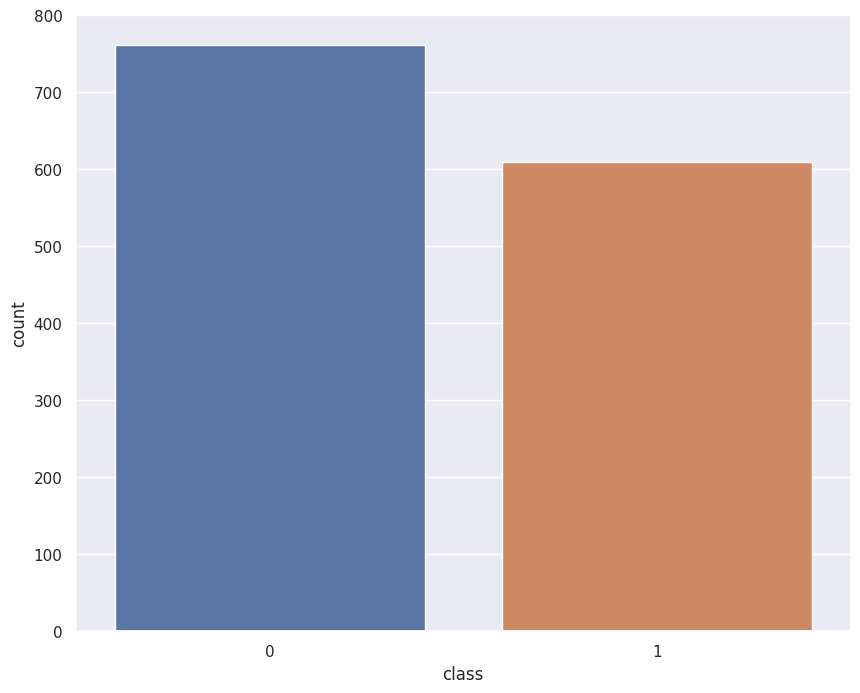

In [51]:
sns.countplot(x="class", data=df)

In [52]:
df["class"].value_counts()

0    762
1    610
Name: class, dtype: int64

Поддельных банкнот больше

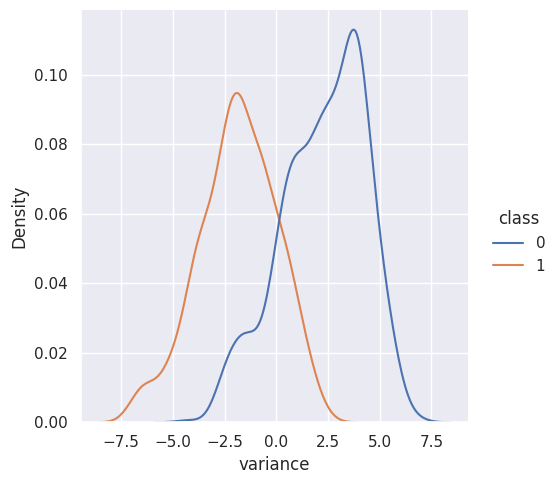

In [53]:
sns.displot(df, x='variance', kind='kde', hue='class', height=5);

Распределение variance для фейковых банкнот и настоящих примерно одинаковые. Однако видно, что у фейковых банкнот пик смещён вправо относительно нуля

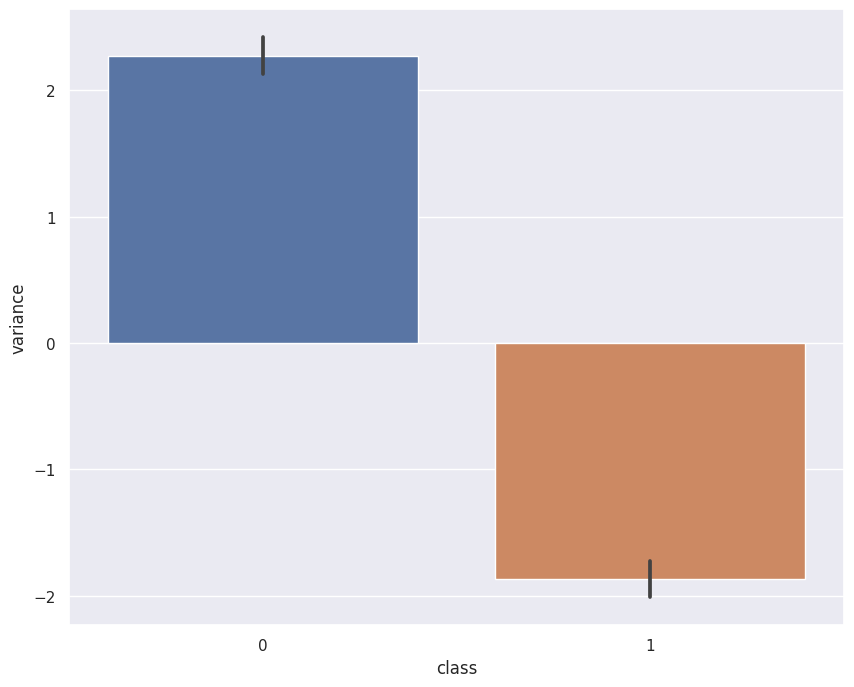

In [54]:
sns.barplot(x ='class', y ='variance', data = df);

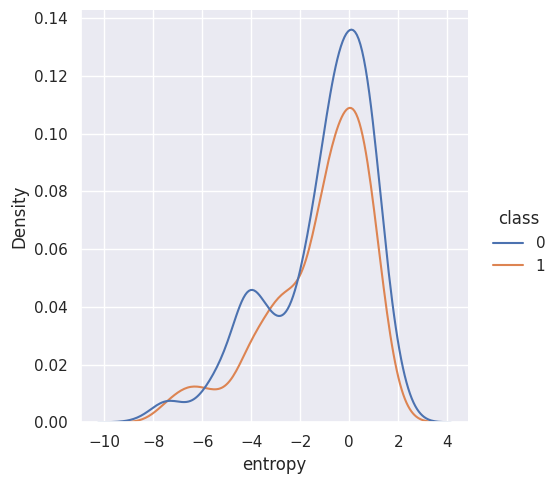

In [55]:
sns.displot(df, x='entropy', kind='kde', hue='class', height=5);

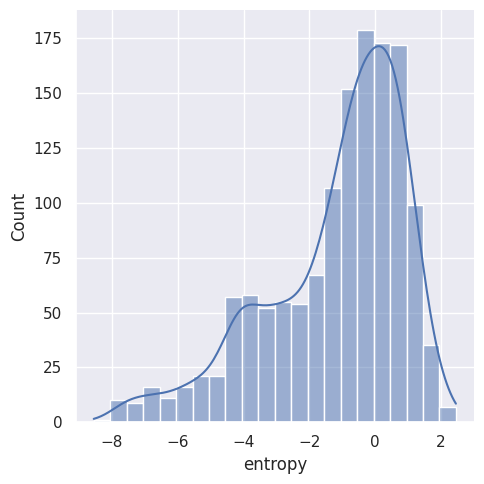

In [56]:
sns.displot(df['entropy'], kde=True);

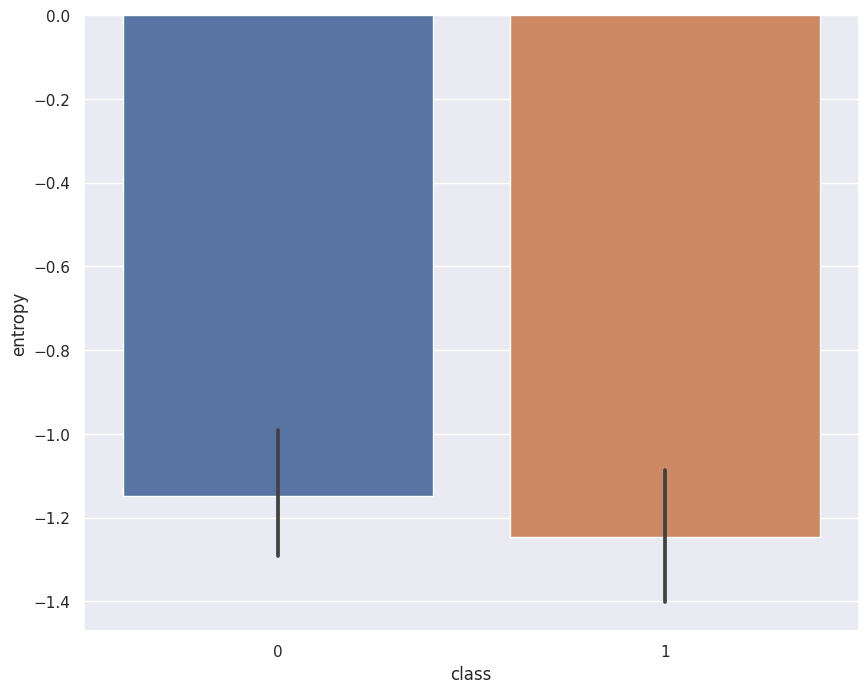

In [57]:
sns.barplot(x ='class', y ='entropy', data = df);

Значение целевого признака практически не зависит от значения энтропии

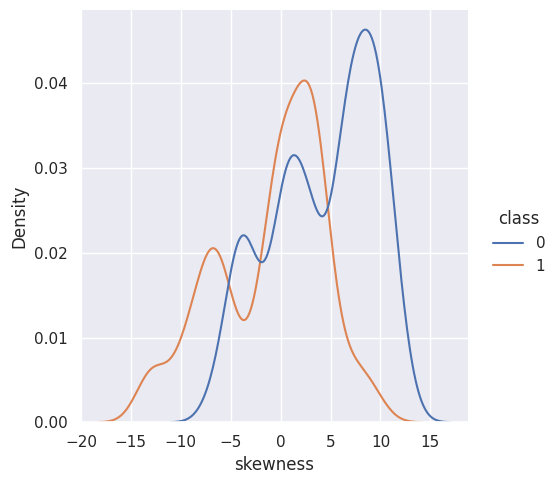

In [58]:
sns.displot(df, x='skewness', kind='kde', hue='class', height=5);

Относительное друг друга распределение для классов 0 и 1 похоже на variance --- для фейковых банкнот заметно смещение в положительные значения.

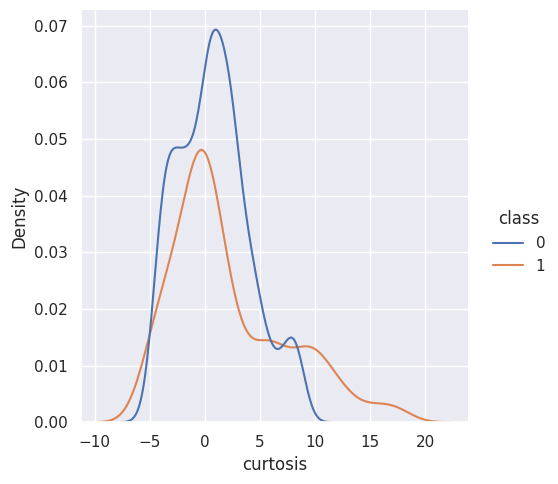

In [59]:
sns.displot(df, x='curtosis', kind='kde', hue='class', height=5);

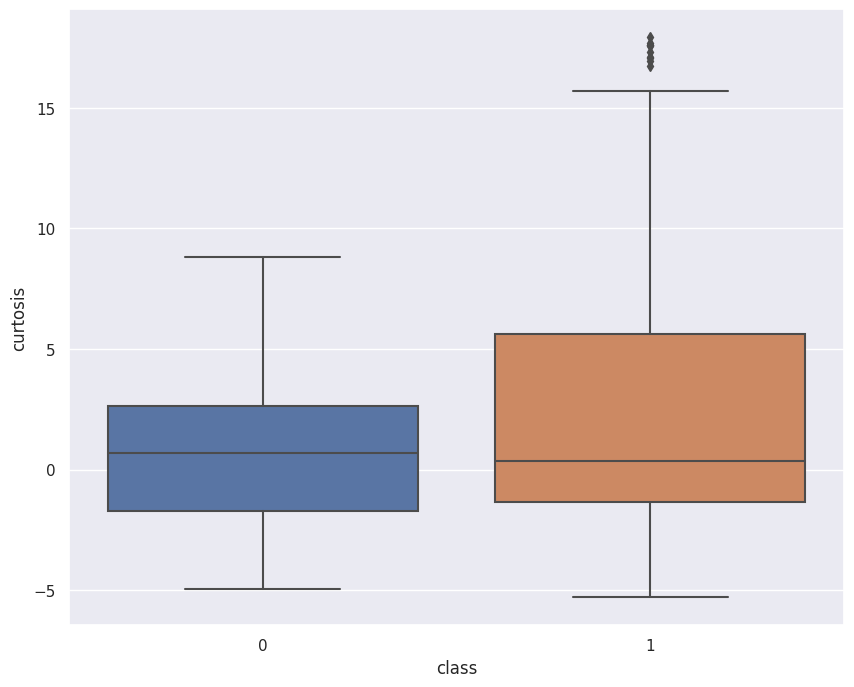

In [60]:
sns.boxplot(x = "class", y = "curtosis", data = df);

Медиана приходится приходится на приблизительно одно значение, однако для настоящих банкнот заметен более сильный разброс в положительные значения, что вполне себе объяснимо -- кривизна у настоящих банкнот может быть выше, т.к они дольше могли быть использованы

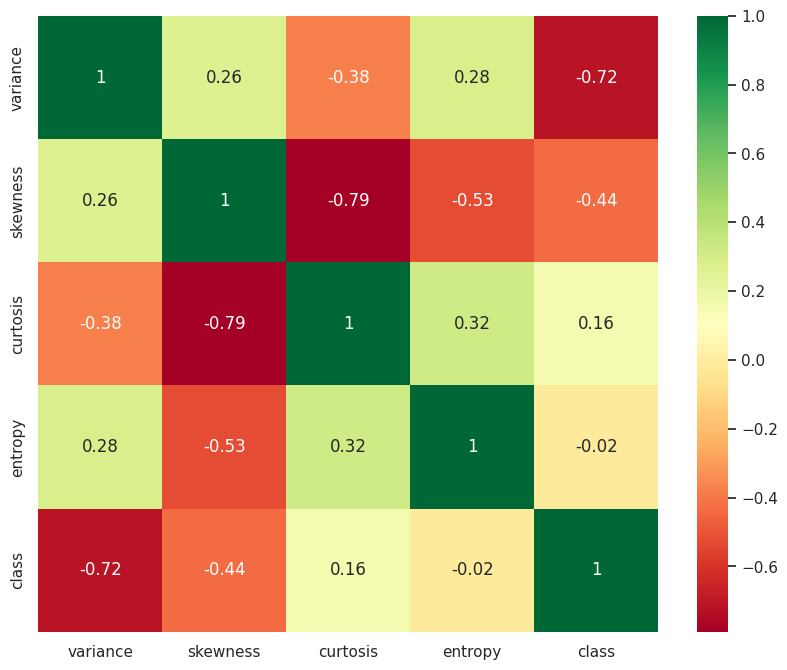

In [61]:
sns.heatmap(round(df.corr(), 2), annot=True, cmap='RdYlGn')
fig = plt.gcf()
plt.show()

Сильная корреляция наблюдается с признаками variance и skewness, меньше с curtosis. Значения корреляции подверждают предыдущие гипотезы.

## Feature engineering

In [62]:
y = df['class']
X = df.drop(columns=['class'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

Все признаки кроме целевого являются численными, можем сразу применить масштабирование

In [63]:
scaler = StandardScaler()  # воспользуемся стандартным трансформером

# масштабируем обучающую выборку и запоминаем среднее, стандартное отклонение признаков
X_train_scaled = scaler.fit_transform(X_train)

# масштабируем тестовую выборку используя статистики обучающей выборки
X_test_scaled = scaler.transform(X_test)

## RFE

In [64]:
rfecv = RFECV(estimator=LogisticRegression())

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

rfecv.fit(X_train_scaled, y_train)
selected_features = list(X_train_scaled.columns[rfecv.support_])

In [65]:
selected_features

['variance', 'skewness', 'curtosis']

RFE ожидаемо избавился от признака entropy, это хорошо, так как какой-либо корреляции с таргетом замечено не было 

In [66]:
X_train_scaled = X_train_scaled[selected_features].to_numpy()
X_test_scaled = X_test_scaled[selected_features].to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [67]:
recalls = dict()
pred = dict()

## My Logistic Regression

In [68]:
from sklearn.metrics import recall_score

In [69]:
searcher = GridSearchCV(
    MyLogisticRegression(),
    [{"threshold": np.logspace(-3, 3, 10)}],
    scoring="f1",
    cv=5
)

searcher.fit(X_train_scaled, y_train);

In [70]:
logreg = MyLogisticRegression(threshold=searcher.best_params_["threshold"])
logreg.fit(X_train_scaled, y_train)
y_pred = logreg.predict(X_test_scaled)
print("Recall MyLogisticRegression: ", recall_score(y_test, y_pred))

recalls["MyLogisticRegression"] = recall_score(y_test, y_pred)
pred["MyLogisticRegression"] = y_pred

Recall MyLogisticRegression:  0.9890710382513661


## Logistic Regression

In [71]:
searcher = GridSearchCV(
    LogisticRegression(),
    param_grid=[{'C': np.logspace(-3, 3, 10)}],
    scoring="f1",
    cv=5,
)

searcher.fit(X_train_scaled, y_train);

In [72]:
logreg = LogisticRegression(C=searcher.best_params_["C"])
logreg.fit(X_train_scaled, y_train)
y_pred = logreg.predict(X_test_scaled)
print("Recall sklearn LogisticRegression: ", recall_score(y_test, y_pred))

recalls["LogisticRegression"] = recall_score(y_test, y_pred)
pred["LogisticRegression"] = y_pred

Recall sklearn LogisticRegression:  0.9890710382513661


## SVM

In [73]:
C = [0.1, 0.25, 0.5, 0.75, 1, 2]
kernel = ["linear", "rbf"]
gamma = ["scale", "auto", 0.0001, 0.001, 0.01, 0.1, 1]

cv = StratifiedKFold(10)

svm = SVC(random_state=11)
grid_svm = GridSearchCV(
    estimator=svm, cv=cv, 
    param_grid=dict(kernel=kernel,C=C, gamma=gamma),
    scoring="f1"
)
grid_svm.fit(X_train_scaled, y_train);

In [74]:
svm = SVC(C=grid_svm.best_params_['C'], gamma=grid_svm.best_params_['gamma'], 
          kernel=grid_svm.best_params_['kernel'], random_state = 11)
svm.fit(X_train_scaled, y_train)
y_pred = svm.predict(X_test_scaled)
print("Recall SVM:", recall_score(y_test, y_pred))

recalls["SVM"] = recall_score(y_test, y_pred)
pred["SVM"] = y_pred

Recall SVM: 1.0


## My KNN

In [75]:
grid_myknn = GridSearchCV(
    estimator=MyKNeighborsClassifier(),
    param_grid=[{'k': [1, 2, 3, 4]}],
    scoring="f1",
    cv=5,
)

grid_myknn.fit(X_train_scaled, y_train);

In [76]:
my_knn = MyKNeighborsClassifier(k=grid_myknn.best_params_['k'])
my_knn.fit(X_train_scaled, y_train)
y_pred = my_knn.predict(X_test_scaled)
print("Recall MyKNN:", recall_score(y_test, y_pred))

recalls["MyKNN"] = recall_score(y_test, y_pred)
pred["MyKNN"] = y_pred

Recall MyKNN: 1.0


## KNN

In [77]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=11)

grid_knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    cv=cv,
    param_grid={"n_neighbors": [1, 2, 3, 4], "weights": ['uniform', 'distance']},
    scoring="f1"
)

grid_knn.fit(X_train_scaled, y_train);

In [78]:
knn = KNeighborsClassifier(n_neighbors=grid_knn.best_params_['n_neighbors'],
                           weights=grid_knn.best_params_['weights'])

knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)
print("Recall KNN:", recall_score(y_test, y_pred))

recalls["KNN"] = recall_score(y_test, y_pred)
pred["KNN"] = y_pred

Recall KNN: 1.0


## NB

In [79]:
priors = [None, [0.62, 0.38]]
var_smoothing = np.logspace(0, -9, num=100)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=11)
grid_nb = GridSearchCV(
    estimator=GaussianNB(),
    cv=cv,
    param_grid={"priors": priors, "var_smoothing": var_smoothing},
    scoring="f1"
)
grid_nb.fit(X_train_scaled, y_train);

In [80]:
nb = GaussianNB(priors=grid_nb.best_params_['priors'],
                var_smoothing=grid_nb.best_params_['var_smoothing'])

nb.fit(X_train_scaled, y_train)
y_pred = nb.predict(X_test_scaled)
print("Recall NB:", recall_score(y_test, y_pred))

recalls["NaiveBayes"] = recall_score(y_test, y_pred)
pred["NaiveBayes"] = y_pred

Recall NB: 0.7595628415300546


## Decision Tree

In [81]:
max_depth = np.arange(7, 15)
min_samples_split = [2, 4, 5, 10]
min_samples_leaf = [1, 2, 4, 6]

cv = StratifiedKFold(10)
grid_tree = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=11),
    cv=5,
    param_grid={'max_depth': max_depth, 
                "min_samples_split": min_samples_split, 
                "min_samples_leaf": min_samples_leaf
    },
    scoring="f1"
)
grid_tree.fit(X_train_scaled, y_train);

In [82]:
dtree = DecisionTreeClassifier(
    max_depth=grid_tree.best_params_['max_depth'],
    min_samples_split=grid_tree.best_params_['min_samples_split'],
    min_samples_leaf=grid_tree.best_params_['min_samples_leaf']
)

dtree.fit(X_train_scaled, y_train)
y_pred = dtree.predict(X_test_scaled)

print("Recall DecisionTree:", recall_score(y_test, y_pred))

recalls["DecisionTree"] = recall_score(y_test, y_pred)
pred["DecisionTree"] = y_pred

Recall DecisionTree: 0.9726775956284153


## Method Comparison

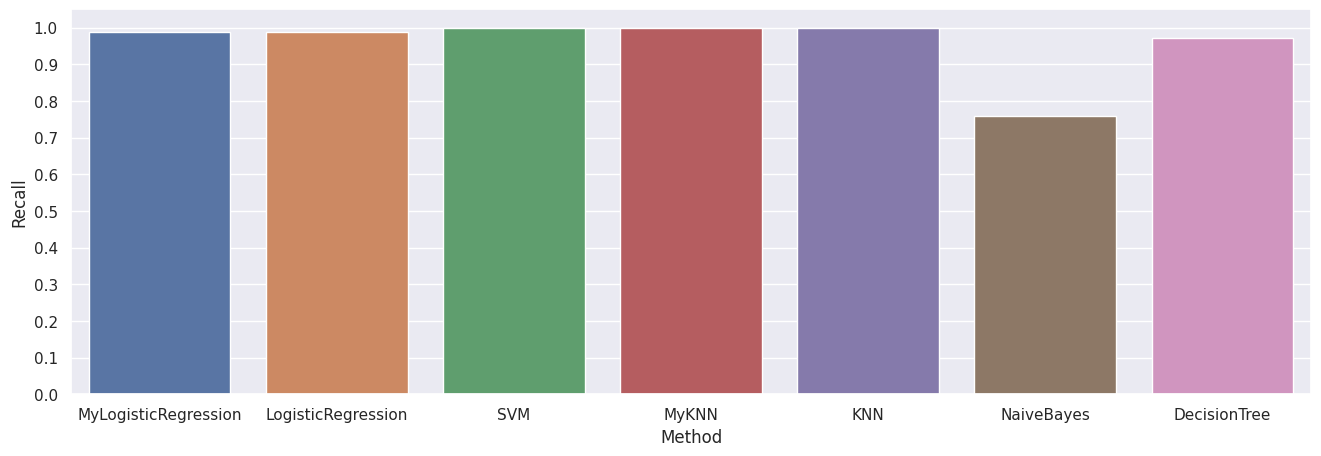

In [83]:
plt.figure(figsize=(16, 5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Recall")
plt.xlabel("Method")
sns.barplot(x=list(recalls.keys()), y=list(recalls.values()))
plt.show()

## Confusion Matrices

In [84]:
cm = {
    key: confusion_matrix(y_test, pred[key]) for key in pred.keys()
}

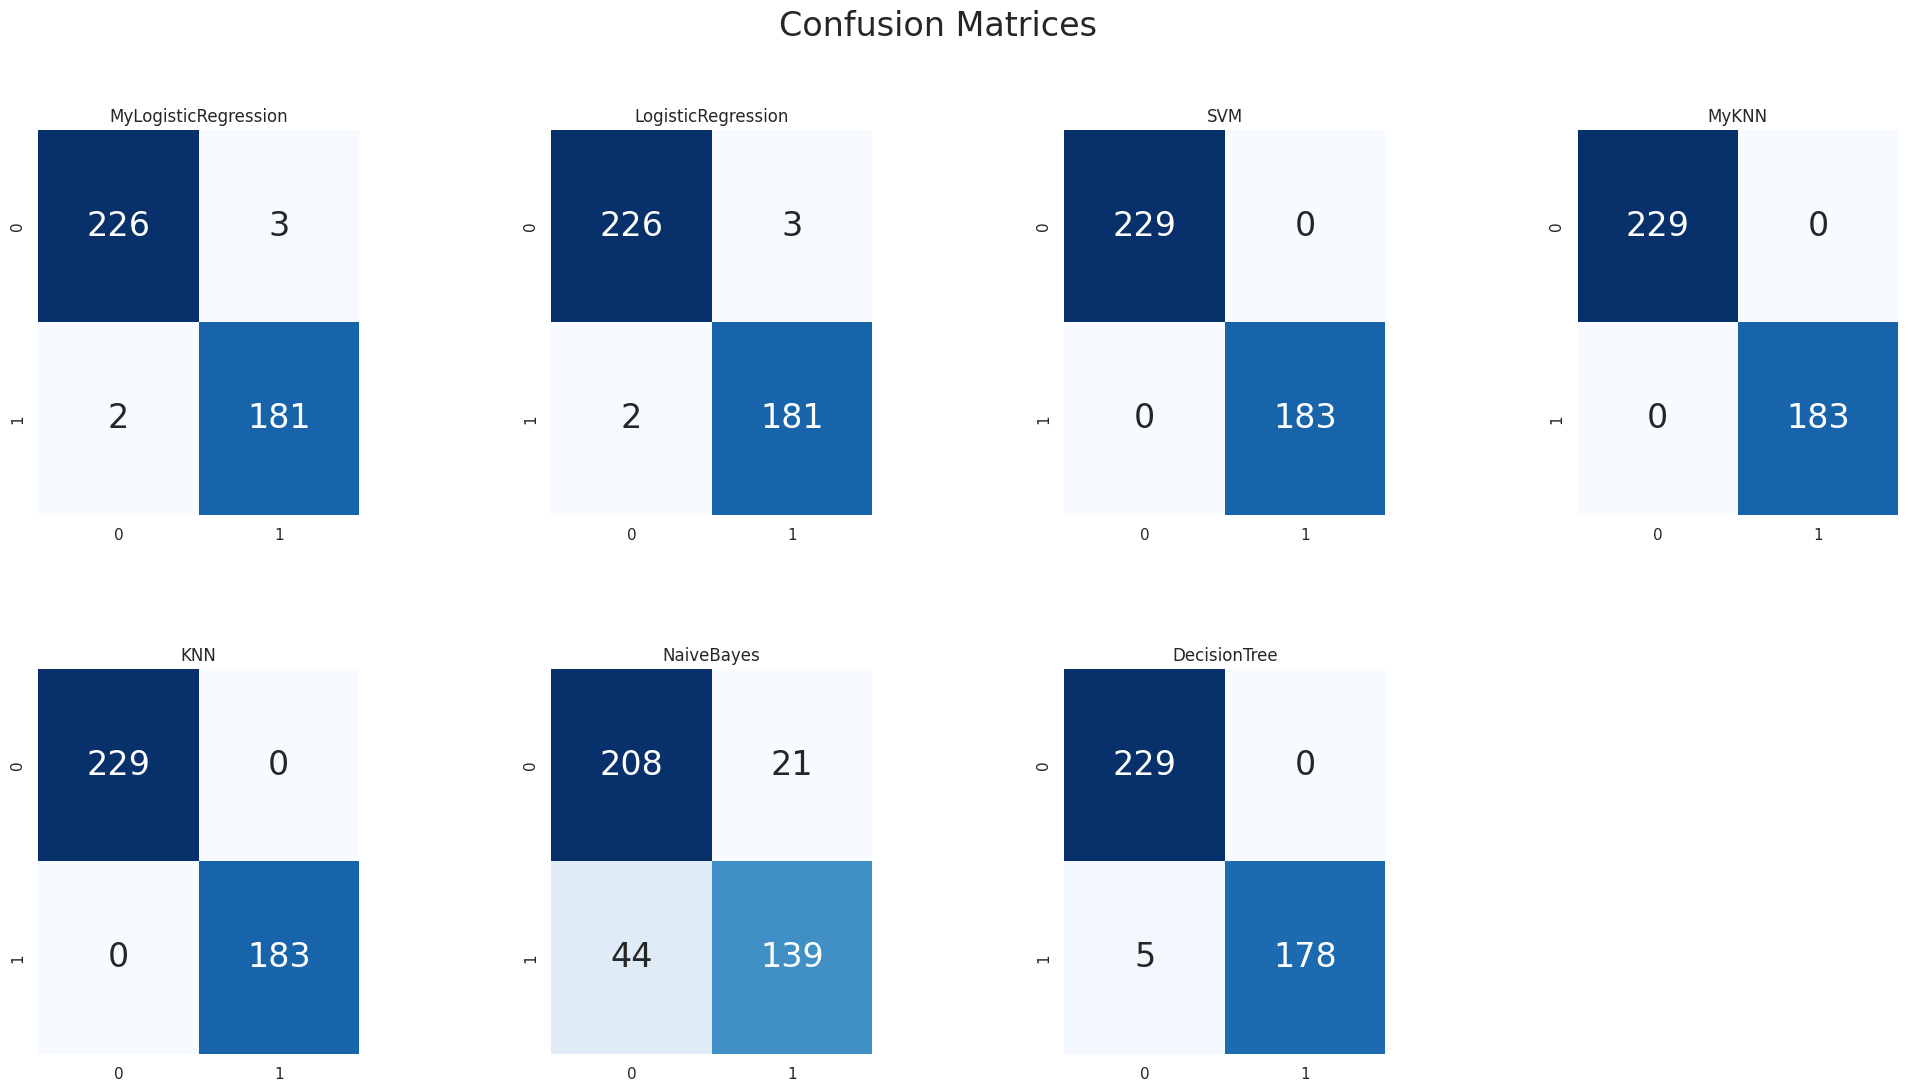

In [85]:
plt.figure(figsize=(24, 12))

plt.suptitle("Confusion Matrices", fontsize=24)
plt.subplots_adjust(wspace=0.6, hspace=0.4)

for i, key in enumerate(cm.keys()):
    plt.subplot(2, 4, i + 1)
    plt.title(key)
    sns.heatmap(cm[key],annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

## Выводы

Собственная реализация логистической регрессии и библиотечная версия показали одинаковые результаты на данном датасете. Лучше всего справились SVM и обе реализации KNN. Заметно хуже всех -- наивный баесовский классификатор

Результаты объяснимы сравнительной простотой модели и достаточно явной корреляцией таргета с остальными признаками